# Capstone 2 Modeling<a id='Modeling'></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [4 Modeling](#Modeling)
    * [4.1 Imports](#Imports)
        * [4.1.1 Import Libraries](#Import_Libraries)
        * [4.1.2 Import Data](#Import_Data)
        * [4.1.3 Import Models](#Import_Models)
    
    * [4.2 Hyperparameter Tuning](#Hyperparameter_Tuning)
        * [4.2.1 Random Search](#Random_Search)
        * [4.2.2 Bayesian Optimization](#Bayesian_Optimization)
    
    * [4.3 Confusion Matrix](#Confusion_Matrix)
    
    * [4.4 Classification Report](#Classification_Report)
    
    * [4.5 Feature Importance](#Feature_Importance)
            
    * [4.6 Modeling_Scenarios](#Modeling_Scenarios)
        * [4.6.1 Providing Discounts](#Providing_Discounts)
        * [4.6.2 Increasing User Engagement](#Increasing_User_Engagement)
        * [4.6.3 Smaller Plans](#Smaller_Plans)
        * [4.6.4 Auto-Renew](#Auto-Renew)
        * [4.6.5 Combining_Scenarios](#Combining_Scenarios)
            * [4.6.5.1 Auto-Renew and Smaller Plans](#Auto-Renew_and_Smaller_Plans)
            * [4.6.5.2 Auto-Renew and Discount](#Auto-Renew_and_Discount)
            * [4.6.5.3 Auto-Renew and Increasing Engagement](#Auto-Renew_and_Increasing_Engagement)
            * [4.6.5.4 All_Four_Scenarios](#All_Four_Scenarios)
        
    * [4.7 Statistical Significance](#Statistical_Significance)
    * [4.8 Estimating Revenue](#Estimating_Revenue)
    * [4.9 Conclusions](#Conclusions)
       


## 4.1 Imports<a id="Imports"></a>

### 4.1.1 Import Libraries<a id="Import_Libraries"></a>

In [1]:
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import recall_score, plot_roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from scipy.stats import chi2_contingency

### 4.1.2 Import Data<a id="Import_Data"></a>

In [2]:
# Read in X_train and y_train
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")

In [3]:
# Read in X_test and y_test 
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

### 4.1.3 Import Models<a id="Import_Models"></a>

In [4]:
# Model with hyperparameters chosen by random search
rs_filepath = "../models/rs_model.pkl"
with open(rs_filepath, "rb") as f:
    rs_model = pickle.load(f)

# Model with hyperparameters chosen by Bayesian optimization
bo_filepath = "../models/bo_model.pkl"
with open(bo_filepath, "rb") as f:
    bo_model = pickle.load(f)

## 4.2 Hyperparameter Tuning<a id="Hyperparameter_Tuning"></a>

The following hyperparameters ranges were set: 

* eta (learning_rate): between 0.3 and 0.9
* max_depth: between 1 and 9
* min_child_weight: between 1 and 7
* colsample_bytree: between 0.1 and 0.8
* gamma: between 0.1 and 0.5
* scale_pos_weight: between 10 and 40

We searched this hyperspace using random search and Bayesian optimization on Google Cloud Platform (GCP). 

Code for this can be found here: https://github.com/bmensah/springboard/tree/main/capstone2/churn_analysis/src 

In [5]:
def show_params(model, param_list):
    """
    Given an xgboost model, print out the parameters listed in param list
    """
    param_dict = model.get_xgb_params()
    for param in param_list:
        print(param, " = ", param_dict[param])

In [6]:
param_list = ["eta","max_depth","min_child_weight", "colsample_bytree", "gamma", "scale_pos_weight"]

### 4.2.1 Random Search<a id="Random_Search"></a>

In [7]:
# Get train set performance
y_pred_train = rs_model.predict(X_train)
print("Train set performance: ", recall_score(y_train, y_pred_train))

# Get test set performance
y_pred_test = rs_model.predict(X_test)
print("Test set performance: ", recall_score(y_test, y_pred_test))

Train set performance:  0.8450567942785023
Test set performance:  0.7495495495495496


In [8]:
# Best parameters chosen by random search 
show_params(rs_model, param_list)

eta  =  0.8700122783177684
max_depth  =  7
min_child_weight  =  1
colsample_bytree  =  0.7360184698196094
gamma  =  0.21419148112497513
scale_pos_weight  =  23.242386300757648


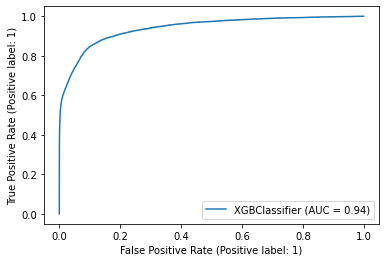

In [9]:
# ROC-AUC curve of model based on test set
plot_roc_curve(rs_model, X_test, y_test);

### 4.2.2 Bayesian Optimization<a id="Bayesian_Optimization"></a>

In [10]:
# Get train set performance
y_pred_train = bo_model.predict(X_train)
print("Train set performance: ", recall_score(y_train, y_pred_train))

# Get test set performance
y_pred_test = bo_model.predict(X_test)
print("Test set performance: ", recall_score(y_test, y_pred_test))

Train set performance:  0.9008413967185528
Test set performance:  0.876976976976977


In [11]:
# Best parameters chosen by Bayesian optimization 
show_params(bo_model, param_list)

eta  =  0.6000000000000001
max_depth  =  5
min_child_weight  =  4
colsample_bytree  =  0.45000000000000007
gamma  =  0.30000000000000004
scale_pos_weight  =  20.0


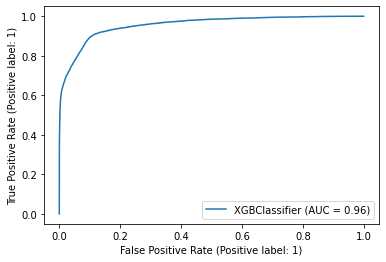

In [12]:
# ROC-AUC curve of model based on test set
plot_roc_curve(bo_model, X_test, y_test);

We will use the model tuned by bayesian optimization going forward as it is better performing than random search across both recall and AUC-ROC.

## 4.3 Confusion Matrix<a id="Confusion_Matrix"></a>

In [13]:
y_pred = bo_model.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

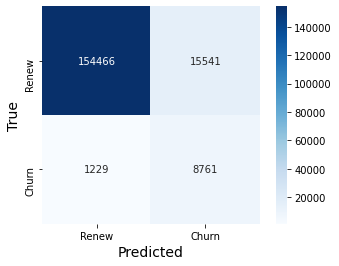

In [14]:
label = ["Renew", "Churn"]
sns.heatmap(pl, annot=True, fmt='.6g', cmap='Blues', square=True, xticklabels=label, yticklabels=label)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show();

## 4.4 Classification Report<a id="Classification_Report"></a>

In [15]:
report = classification_report(y_test, y_pred, target_names=["Renew", "Churn"])
print(report)

              precision    recall  f1-score   support

       Renew       0.99      0.91      0.95    170007
       Churn       0.36      0.88      0.51      9990

    accuracy                           0.91    179997
   macro avg       0.68      0.89      0.73    179997
weighted avg       0.96      0.91      0.92    179997



## 4.5 Feature Importance<a id="Feature_Importance"></a>

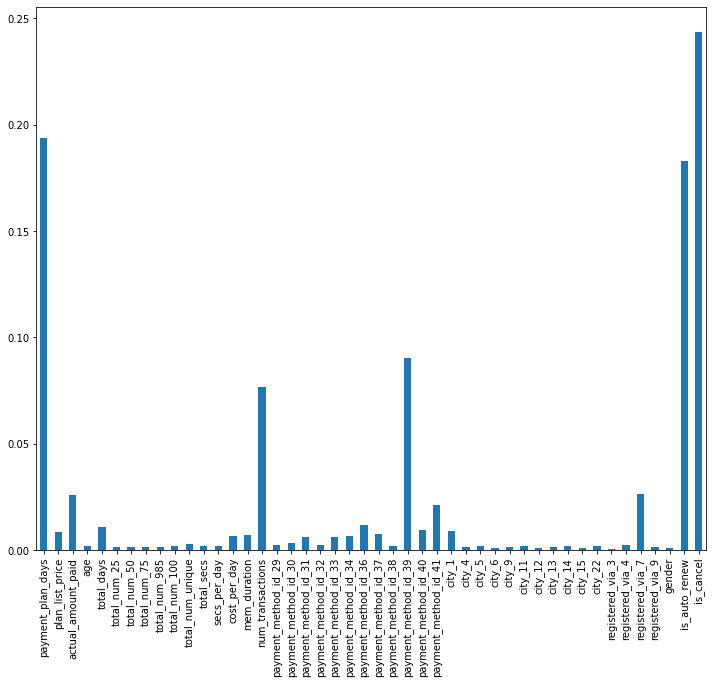

In [16]:
feat_importance = pd.DataFrame(bo_model.feature_importances_, index=X_test.columns.to_list())
feat_importance.plot(kind="bar", figsize=(12,10), legend=None)
plt.show();

Whether or not a user has canceled the service has the most significant effect on predicting churn, but this is a mostly negligible result as the very definition of churn includes that a user has canceled their subscription and made no new transactions within 30 days. 

It is very interesting to see the importance of the length and price of subscriptions. In the heatmap produced in EDA, we also saw that these features were highly correlated with churn. 

The is_auto_renew option did not appear to have a clear correlation with churn in EDA, but we see here that it is an important feature. 

The number of transactions and payment_method_id_39 have an outsized influence on the model as well, which was not evident in EDA. 

## 4.6 Modeling Scenarios<a id="Modeling_Scenarios"></a>

In our problem statement, our criteria of success was defined as showing a statistically significant decrease in churn in the upcoming month, April 2017. 

With this goal in mind, let's examine KKBox's current situation. 

This chart of the number of new subscribers added each month since KKBox's founding in 2004 reveals that while overall the number of new subscribers has been increasing, there has been a sharp downward trend in recent months:

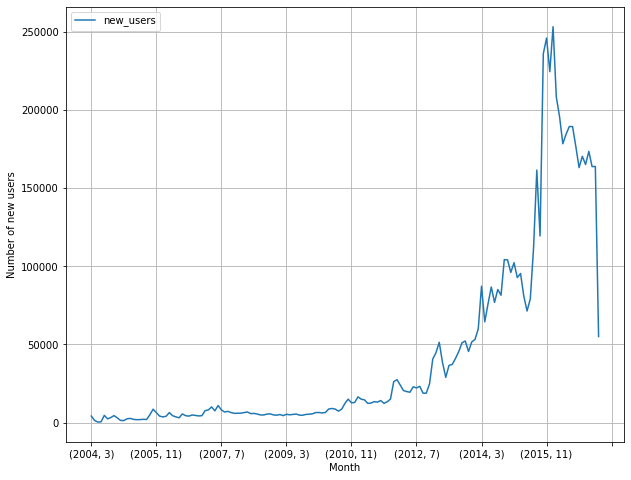

In [17]:
# Read in members_v3.csv file
members_df = pd.read_csv("../data/raw/members_v3.csv")

# Find the number of new subscribers who registered each month 
members_df["registration_init_time"] = pd.to_datetime(members_df["registration_init_time"], format="%Y%m%d")
monthly_new_users = {}
for year in range(2004, 2017+1):
    for month in range(1, 12+1):
        num_new_users = sum((members_df["registration_init_time"].dt.year==year) & \
                         (members_df["registration_init_time"].dt.month==month))
        monthly_new_users[(year,month)] = num_new_users
        
# Graph the number of new users added each month 
new_users_df = pd.DataFrame.from_dict(monthly_new_users, orient="index", columns=["new_users"])

# drop months at the extremities that have no data, as well as our current month
new_users_df = new_users_df[new_users_df.new_users>0].drop((2017,3))

new_users_df.plot(figsize=(10,8),grid=True)
plt.xlabel("Month")
plt.ylabel("Number of new users")
plt.show();

Furthermore, the percentage of new subscribers who churn is significantly higher than the percentage of older subscribrs who churn. Thus, at the same time that the number of new subscribers is dwindling, those who do sign up for the service are churning at higher rates: 

In [18]:
# Read in fully wrangled dataset 
original_data = pd.read_csv("../data/processed/combined.csv")

Percent of subscribers who both registered and churned in March 2017: 18.22%
Percent of subscribers who churned overall: 5.63%


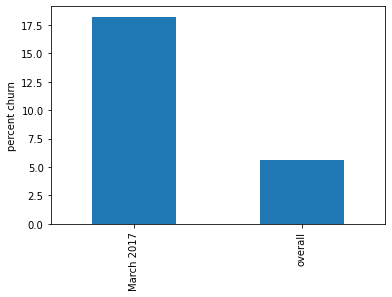

In [19]:
# Number subscribers who both registered and churned in March 2017
original_data["registration_init_time"] = pd.to_datetime(original_data["registration_init_time"].astype(str), 
                                                         format="%Y%m%d")
first_time = original_data[(original_data["registration_init_time"].dt.year==2017) & \
                           (original_data["registration_init_time"].dt.month==3)]
new_user_pct_churn = (first_time.is_churn.value_counts()[1] / first_time.shape[0])*100
overall_pct_churn = (original_data.is_churn.value_counts()[1] / original_data.shape[0])*100
print("Percent of subscribers who both registered and churned in March 2017: {:.2f}%".format(new_user_pct_churn))
print("Percent of subscribers who churned overall: {:.2f}%".format(overall_pct_churn))

# Graph comparing percent churn in March 2017 to churn overall
compare_churn = pd.DataFrame.from_dict({"March 2017":new_user_pct_churn, "overall":overall_pct_churn}, 
                                          orient="index", columns=["percent churn"])
compare_churn.plot(kind="bar", ylabel="percent churn", legend=None);

The number of new subscribers registering each month is dropping, and the subscribers who do register are churning at higher rates than the overall churn rate. 

The combination of these challenges makes an adjustment to KKBox's strategy for retaining subscribers all the more essential to implement as soon as possible.  

In [20]:
# Function to test new scenarios
def scenario(columns, change, model=bo_model, test_data=X_test, old_pred=y_pred):
    """
    Given columns and a change, applys change to given columns in test set
    Parameters:
        columns: columns to apply change to in order to model a scenario
         change: value to multiply the given columns by to simulate a change
          model: defaults to the xgboost model tuned by Bayesian optimization as defined above
           data: defaults to a copy of the test data with a "churn_risk" column to identify 
                   subscribers at risk of churn
       old_pred: defaults to predicted churn by xgboost model 
       
    Returns:
        Dataframe with changes for the scenario applied
        prints three statements:
            1. amount of churn predicted without the changes
            2. about of churn with changes applied
            3. percent difference in churn
            
    """
    # Copy test data so we don't make changes to the original test dataset 
    data = test_data.copy()
    data["churn_risk"] = old_pred
    mask = data["churn_risk"]==1
    data.loc[mask, columns] = data.loc[mask, columns] * change
    data = data.drop("churn_risk", axis=1)
    new_pred = model.predict(data)
    print("Total churn in test set without change:", sum(old_pred))
    print("Total churn in test set with change:", sum(new_pred))
    count = data.shape[0]
    pct_decrease = ((sum(old_pred)-sum(new_pred))/sum(old_pred))*100
    print("Percent decrease in churn: {:.2f}%".format(pct_decrease))
    return data
    

### 4.6.1 Providing Discounts<a id="Providing_Discounts"></a>

We will apply a 50% discount to the subscribers that our model predicted will churn, the predict churn again. 

In [21]:
discounts = scenario("actual_amount_paid", 0.5);

Total churn in test set without change: 24302
Total churn in test set with change: 24016
Percent decrease in churn: 1.18%


Giving subscribers at risk of churn a 50% discount did make a slight difference in likelyhood to churn. However, this stratey should be considered in the light of the central objective, which is increasing revenue.

### 4.6.2 Increasing User Engagement<a id="Increasing_User_Engagement"></a>

In EDA, we saw that user engagement did not appear to have a significant impact on likelyhood of churning. Let's test if that holds true for our models predictions by multiplying the amount of time the users at risk of churn spend on the app by 20%. 

In [22]:
user_logs = ['total_num_25', 'total_num_50', 'total_num_75',
       'total_num_985', 'total_num_100', 'total_num_unique']

more_engagement = scenario(user_logs, 1.2);

Total churn in test set without change: 24302
Total churn in test set with change: 22278
Percent decrease in churn: 8.33%


Surprisingly, getting users to engage more with the app is predicted to lead to a decrease in churn.

### 4.6.3 Smaller Plans<a id="Smaller_Plans"></a>

In the EDA stage, we observed that users who churned were paying three times as much for their subscriptions and had signed up for plans lasting three times as long. Additionally, in the graph of feature importance above, we see that the length and cost of plans are the most important features our model identified in determining likelyhood of churn. 

Let's reduce the plan length and amount paid for subscribers at risk of churn to a third of the original amounts: 

In [23]:
smaller_plans = scenario(["payment_plan_days", "plan_list_price", "actual_amount_paid"], 0.33)

Total churn in test set without change: 24302
Total churn in test set with change: 23807
Percent decrease in churn: 2.04%


Against our observations in EDA, switching subscribers at risk of churn to shorter plans with smaller monthly costs does not appear to reduce churn in a significant way with this change alone. 

### 4.6.4 Auto-Renew<a id="Auto-Renew"></a>

In EDA, we did not see auto-renew have a significant effect on churn. We will have all subscribers at risk of churn sign up for auto-renew, then predict how this change will affect their likelyhood of churn. 

In [24]:
auto_renew = X_test.copy()
auto_renew["churn_risk"] = y_pred

# Find subscribers at risk of churn and sign them up for auto-renew
mask = auto_renew["churn_risk"] == 1
auto_renew.loc[mask, "is_auto_renew"] = 1
new_pred = bo_model.predict(auto_renew.drop("churn_risk", axis=1))
count = len(new_pred)
pct_decrease = ((sum(y_pred)-sum(new_pred))/sum(y_pred))*100
print("Total churn in test set without change:", sum(y_pred))
print("Total churn in test set with change:", sum(new_pred))
print("Percent decrease in churn: {:.2f}%".format(pct_decrease))

Total churn in test set without change: 24302
Total churn in test set with change: 12917
Percent decrease in churn: 46.85%


Our model predicts that signing up subscribers at risk of churn to auto-renew would decrease churn by almost half!

### 4.6.5 Combining Scenarios<a id="Combining_Scenarios"></a>

A combination of scenarios could lead to greater success. 

Let's first model how much churn would decrease if all subscribers at risk of churn signed up for auto-renew and got their subscriptions restructured to be monthly subscriptions (a third of what they were paying before, on average).

#### 4.6.5.1 Auto-Renew and Smaller Plans<a id="Auto-Renew_and_Smaller_Plans"></a>

In [25]:
ar_and_sm = scenario(["payment_plan_days", "plan_list_price", "actual_amount_paid"], 0.33, test_data=auto_renew)

Total churn in test set without change: 24302
Total churn in test set with change: 11962
Percent decrease in churn: 50.78%


Now, let's model the effect of providing a 50% off discount and auto-renew to those subscribers at risk of churn:

#### 4.6.5.2 Auto-Renew and Discount<a id="Auto-Renew_and_Discount"></a>

In [26]:
ar_and_disc = scenario("actual_amount_paid", 0.5, test_data=auto_renew);

Total churn in test set without change: 24302
Total churn in test set with change: 12570
Percent decrease in churn: 48.28%


Finally, let's combine increasing user engagement by 20% and auto-renew: 

#### 4.6.5.3 Auto-Renew and Increasing Engagement<a id="Auto-Renew_and_Increasing_Engagement"></a>

In [27]:
ar_and_ie = scenario(user_logs, 1.2, test_data=auto_renew);

Total churn in test set without change: 24302
Total churn in test set with change: 12435
Percent decrease in churn: 48.83%


#### 4.6.5.4 All Four Scenarios<a id="All_Four_Scenarios"></a>

In [28]:
# First, combine auto-renew, increaing engagement by 20%, and discount
ar_ie_and_disc = scenario("actual_amount_paid", 0.5, test_data=ar_and_ie);

Total churn in test set without change: 24302
Total churn in test set with change: 12172
Percent decrease in churn: 49.91%


In [29]:
# Combine all four scenarios
combined = scenario(["payment_plan_days", "plan_list_price", "actual_amount_paid"], 0.33, test_data=ar_ie_and_disc)

Total churn in test set without change: 24302
Total churn in test set with change: 11629
Percent decrease in churn: 52.15%


We get the best results when we combine all four scenarios, with 52.15% of subscribers at risk of churn retained when they get a 50% off discount, plans restrucured to be monthly plans, sign up for auto-renew, and listen to more music.

## 4.7 Statistical Significance<a id="Statistical_Significance"></a>

Is this decrease in churn statistically significant? 

__Null hypothesis:__ There is no relationship between the selected features (user engagement with the app, subscription cost and duration, and getting a discount) and likelyhood of churn. 

In [30]:
# Build a contingency table 
old_prediction = pd.Series(y_pred).value_counts()
new_prediction = pd.Series(bo_model.predict(combined)).value_counts()
contingency_table = pd.DataFrame({"old_prediction":old_prediction, 
                                "new_prediction": new_prediction})
contingency_table = contingency_table.rename({0:"renew", 1:"churn"})
contingency_table

,old_prediction,new_prediction
renew,155695,168368
churn,24302,11629


In [31]:
# Get the statistic, p-value, degrees of freedom, and expected frequencies
stat, p, dof, expected = chi2_contingency(contingency_table)

In [32]:
print("p_value: {:.20f} ".format(p))

p_value: 0.00000000000000000000 


With a p_value this low, we can confidently conclude that our results are statistically significant. We can reject the null hypothesis and confidently predict that convincing subscribers at risk of churn to sign up for auto-renew, increasing user engagement, changing all subscriptions to be monthly, and providing subscribers at risk of churn with a 50% discount all have an effect on churn. 

## 4.8 Estimating Revenue<a id="Estimating_Revenue"></a>

While it is encouraging to see that there are pathways to reducing churn, as two of these scenarios involve reducing the amount paid per month of subscribers, it is not certain that reducing churn via these methods would increase revenue. Let's estimate revenue given the proposed changes and determine which adjustments would be worthwhile. 

NOTE: Since our data is for March 2017, these calculations for KKBox's revenue in April 2017 should only be considered as rough estimates. Other factors, such as the amount of new subscribers in April, cannot be taken into account. 

In [33]:
# Calculate subscription revenue without any changes
march_revenue = original_data[original_data.is_churn==0].actual_amount_paid.sum()
print("Subscription revenue from March 2017:", f'{march_revenue:,}', "NT$")

Subscription revenue from March 2017: 74,589,501 NT$


### 4.8.1 Estimating Revenue with No Price Changes<a id="Estimating_Revenue_with_No_Price_Changes"></a>

Two of the scenarios modeled require a decrease in prices: giving subscribers at risk of churn a 50% discount and restructuring plans lasting more than 30 days to be monthly plans. 

Two of the scenarios do not require a change in prices: having subscribers sign up for auto-renew and increasing user engagement with the app by 20%. However, this could lead to an increase in costs for advertising the auto-renew feature and new services to increase engagement. 

By applying all four scenarios, churn is reduced by 52.15%. But this is only 3.32% more than the decrease when only the auto-renew and increasing engagement scenarios are applied. Which combination of scenarios is best for the ultimate goal of increasing revenue?  

Let's first calculate the increase in revenue when KKBox invests in signing up subcribers for auto-renew and increasing engagement on the app by 20%. Above, we saw that this would lead to a 48.83% drop in churn:

In [34]:
calc_revenue = original_data[["actual_amount_paid", "payment_plan_days", "is_churn"]]

# Get 48.83% of total churn
limit = round(sum(calc_revenue.is_churn==1) * .4883)

# Order by is_churn so that 1s are gathered on top of the column
calc_revenue = calc_revenue.sort_values("is_churn", ascending=False)

# Switch 48.83% of churn values from 1 to 0
calc_revenue.iloc[0:limit, 2] = 0

new_revenue = calc_revenue[calc_revenue.is_churn==0].actual_amount_paid.sum()

print("Estimated revenue with 48.83% less churn:", f'{new_revenue:,}', "NT$")
print("Percent increase:", f'{round(((new_revenue-march_revenue)/march_revenue)*100,2):,}', "%")

Estimated revenue with 48.83% less churn: 80,933,560 NT$
Percent increase: 8.51 %


With 48.83% of subscribers at risk of churn retained, KKBox's estimated subscription revenue for April 2017 is 80,933,560 NT$, an increase of 8.51%. 

Now, let's consider the scenarios where price is affected: the 50% percent off discount and the restructuring of subscriptions lasting more than 30 days to be monthly:

### 4.8.2 Estimating Revenue with Discounts and Restructured Plans<a id="Estimating_Revenue_with_Discounts_and_Restructured_Plans"></a>

In [35]:
calc_revenue = original_data[["actual_amount_paid", "payment_plan_days", "is_churn"]]

# Get 52.15% of total churn
limit = round(sum(calc_revenue.is_churn==1) * .5215)

# Order by is_churn so that 1s are gathered on top of the column
calc_revenue = calc_revenue.sort_values("is_churn", ascending=False)

# Switch 52.15% of churn values from 1 to 0
calc_revenue.iloc[0:limit, 2] = 0

# Apply 50% off for subscribers at risk of churn
calc_revenue.iloc[0:limit, 0] = calc_revenue.iloc[0:limit, 0]*0.5

# Apply plan restructuring for those subscribers 
calc_revenue["payment_plan_months"] = calc_revenue["payment_plan_days"]/30
calc_revenue = calc_revenue.drop("payment_plan_days", axis=1)
calc_revenue.iloc[0:limit, 0] = calc_revenue.iloc[0:limit, 0]/calc_revenue.iloc[0:limit, 2]

# Calculate revenue
changed_revenue = calc_revenue[calc_revenue.is_churn==0].actual_amount_paid.sum()
print("Estimated revenue with churn prevention measures applied and factored into price:",
                     f'{round(changed_revenue,2):,}', "NT$")
print("Percent increase:", f'{round(((changed_revenue-march_revenue)/march_revenue)*100,2):,}', "%")

Estimated revenue with churn prevention measures applied and factored into price: 75,784,580.51 NT$
Percent increase: 1.6 %


With the changes to price factored in, the estimated revenue increase from retaining 52.15% of subscribers at risk of churn drops from 8.51% to 1.6%. 

Therefore, even though more subscribers are retained when they are given a discount and plans are restructured, the best option to increase revenue as much as possible is to simply focus on getting subscribers signed up for auto-renew and increasing user enagagement with the app.

### 4.8.3 Estimating Revenue with A Price Increase<a id="Estimating_Revenue_with_a_Price_Increase"></a>

How much would churn increase by if prices went up? Does KKBox have room to charge more for their service, while retaining the same amount of subscribers?

What effect would increasing price have on churn? 

In [36]:
increases = [1.05, 1.1, 1.25, 1.5, 2]
prev_pred = bo_model.predict(X_test)
prev_churn_total = prev_pred.sum()

for inc in increases:
    costs = X_test.copy()
    
    # Apply price increase to all subscribers 
    print("Multiply cost by:", inc)
    costs["actual_amount_paid"] = costs["actual_amount_paid"]*inc
    
    # Predict on new data
    new_pred = bo_model.predict(costs)
    new_churn_total = new_pred.sum()
    
    # Print results
    print("Total churn in test set without change:", prev_churn_total)
    print("Total churn in test set with change:", new_churn_total)
    pct_change = ((prev_churn_total-new_churn_total)/prev_churn_total)*100
    print("Percent decrease in churn: {:.2f}%".format(pct_change))
    print("\n", "----------------", "\n")
    

Multiply cost by: 1.05
Total churn in test set without change: 24302
Total churn in test set with change: 24372
Percent decrease in churn: -0.29%

 ---------------- 

Multiply cost by: 1.1
Total churn in test set without change: 24302
Total churn in test set with change: 24372
Percent decrease in churn: -0.29%

 ---------------- 

Multiply cost by: 1.25
Total churn in test set without change: 24302
Total churn in test set with change: 24372
Percent decrease in churn: -0.29%

 ---------------- 

Multiply cost by: 1.5
Total churn in test set without change: 24302
Total churn in test set with change: 24370
Percent decrease in churn: -0.28%

 ---------------- 

Multiply cost by: 2
Total churn in test set without change: 24302
Total churn in test set with change: 24370
Percent decrease in churn: -0.28%

 ---------------- 



So based on our model, KKBox could double prices for all subscribers and churn would only increase by 0.28%. Quite obviously, our data is not suited to answer this question.  

## 4.9 Conclusions<a id="Conclusions"></a>

We began with this Problem Statement:

__What opportunities exist for KKBox to report a positive percent change in revenue by the end of the current quarter through subscriber retention, attracting new subscribers, or increasing prices?__

While the number of new subscribers KKBox adds per month has increased since 2004, there has been a significant decrease in new subscribers since 2015. Therefore, we cannot rely on attracting new subscribers alone to lead to an increase in revenue. 

After modeling various scenarios, we found that by addressing the following, KKBox could decrease churn by 52.15%:
* convincing subcribers at risk of churn to sign up for auto-renew
* restructuring any subscriptions longer than 30 days to be monthly 
* provide subscribers at risk of churn with a 50% off discount for one month
* increase user engagement by 20%

With all four of these scenarios combined, revenue is projected to increase by only 1.6%.

If KKBox invests instead in only two of these scenarios, convincing subscribers to sign up for auto-renew and increasing user engagement by 20%, revenue is projected to increase by 8.51%. 3.32% less subscribers are retained with these two scenarios alone. However, the price decreases required to keep more subscribers are not worthwhile if increasing revenue is the primary goal.  

__Further Analysis__

The final solution explored, increasing prices, is inconclusive. The model predicts that doubling prices would lead to only a 0.28% increase in churn. This result is misleading. Doubling the price of the service would likely discourage many subscribers from using the app and increase churn by much more than 0.28%. 

The data provided is not suited to truly answer this question. In order to truly determine the effect of an increase of price on churn, we would need new data. Data on the cost and features in plans by competing services is necessary to truly gauge how much increasing prices would affect churn.

KKBox did see a sharp increase in new subscribers in the months leading up to the current drop. Further analysis should be done on what changed between the large upswing in new subscription and the current downturn to determine what changes could be made to return to positive growth in new subscriptions. 